# Modificaciones ARIADNE

## Modelo

En `sed_fitting.py`, la función `model_grid` contiene el modelo que se ajusta. Por defecto es

$$ M = F \times \frac{R}{D}^2 $$

Que es justamente lo que [utiliza VOSA](http://svo2.cab.inta-csic.es/theory/vosa/helpw4.php?otype=star&action=help&what=fitbin) pero en el caso de una estrella. Es decir, hay que modificarlo a 

$$ M = F_1 \times \frac{R_1}{D}^2 + F_2 \times \frac{R_2}{D}^2 $$

Esto implica tener dos parámetros para el radio, además de duplicar los que necesite la función del flujo, para generar $F_2$

## Fit

Esta parte en principio no debería modificarse. Lo normal es que ARIADNE haga el BMA y todo lo que hace usualmente, pero por ahora no hay intenciones de cambiar eso. En el futuro sería deseable calcular la evidencia del modelo binario vs el single, si es que no hay una forma más eficiente de comparar modelos.

Lo que hace es obtener los residuos con `get_residuals`, que también devuelve los errores. Con esto se construye el likelihood via `log_likelihood`

Por tanto, lo que parece ser ideal es generar otra función `model_grid` al menos, que considere el caso binario. Luego queda ver si es necesario clonar las otras funciones para generar el likelihood o si se puede ser más directo.

## Pruebas

Para comenzar a ver si está funcionando bien y ser más eficientes en tiempo, partir por ajustar solo un parámetro y dejar los otros fijos. Verificar si se recupera el resultado correcto, comparar con caso single.

Ojalá recuperar los valores de la literatura para un sistema binario bien caracterizado, comparar qué tan cerca da, errores, etc.

## Dudas
ARIADNE permite dejar el radio fijo? Y otros valores como teff, logg, z? Me parece que si, hay que revisar la parte de los priors.

Podré ejecutar todo esto acá para hacer pruebas? Sin tener que modificar el codigo y reinstalar. Me parece que también sí, mientras pueda importar las funciones necesarias.

In [53]:
from astroARIADNE.star import Star

#V* V1334 Cyg
#ra = 319.8424131369400
#dec = 38.2374635626800
#starname = 'V* V1334 Cyg'
#gaia_id = 1964855904803120640

#OGLE LMC-CEP-144
ra = 72.5020950102900
dec = -66.7316936244600
starname = 'OGLE LMC-CEP-144'
gaia_id = 4662508302029459456

#OGLE LMC-CEP-0227
ra = 73.0654083127800
dec = -70.2420117717800
starname = 'LMC-CEP-0227'
gaia_id = 4654937339840486528

#Ejemplo
#ra = 75.795
#dec = -30.399
#starname = 'NGTS-6'
#gaia_id = 4875693023844840448

s = Star(starname, ra, dec, g_id=gaia_id)


		#####################################
		##             ARIADNE             ##
		#####################################
   spectrAl eneRgy dIstribution bAyesian moDel averagiNg fittEr

			Author : Jose Vines
			Contact : jose . vines at ug . uchile . cl
			Star : LMC-CEP-0227
		*** LOOKING UP ARCHIVAL INFORMATION ***
INFO: Query finished. [astroquery.utils.tap.core]
Warning!: CatalogWarning
Warning message: Parameter radius not found! Be advised.
Warning!: CatalogWarning
Warning message: Parameter lum not found! Be advised.
INFO: Query finished. [astroquery.utils.tap.core]
Star not found in catalog TYCHO2.
INFO: Query finished. [astroquery.utils.tap.core]
Star not found in catalog Pan-STARRS.
INFO: Query finished. [astroquery.utils.tap.core]
Star not found in catalog SDSS.
INFO: Query finished. [astroquery.utils.tap.core]
Star not found in catalog Wise.
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
Looking online for archival magni

In [70]:
mask = s.filter_mask
flxs = s.flux[mask]
errs = s.flux_er[mask]
filts = s.filter_names[mask]
wave = s.wave[mask]

print(filters)
print(wave)

['GROUND_JOHNSON_B' 'SDSS_g' 'GaiaDR2v2_BP' 'GROUND_JOHNSON_V' 'SDSS_r'
 'GaiaDR2v2_G' 'SDSS_i' 'GaiaDR2v2_RP' 'TESS' '2MASS_J' '2MASS_H'
 '2MASS_Ks']
[0.43475261 0.47188722 0.51289652 0.5504666  0.61851945 0.64249309
 0.74997042 0.7799195  0.79723607 1.2408376  1.65136646 2.16558387]


(0.1, 6.0)

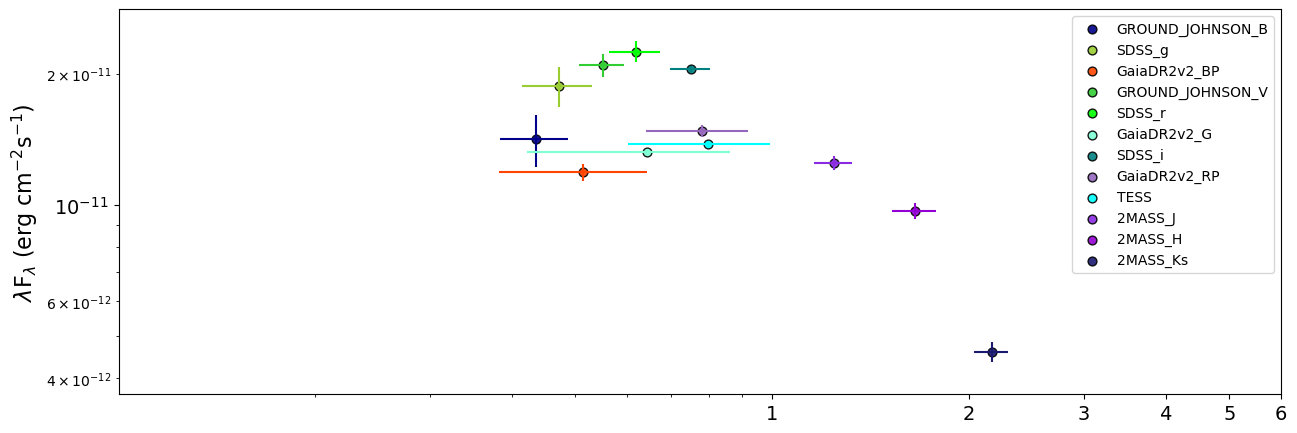

In [55]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

ymin = (flxs * wave).min()
ymax = (flxs * wave).max()

f, ax = plt.subplots(figsize=[15,5])

# Model plot
used_f = s.filter_names[s.filter_mask]

colors = np.array(['tomato', 'indianred', 'tab:red',
            'salmon', 'coral',
            'mediumorchid', 'mediumslateblue', 'tab:blue',
            'darkslateblue', 'darkblue',
            'olivedrab', 'yellowgreen', 'greenyellow', 'yellow',
            'orangered', 'chocolate', 'khaki',
            'limegreen', 'darkgreen', 'lime', 'seagreen', 'lawngreen', 'green',
            'aquamarine', 'turquoise', 'lightseagreen', 'teal', 'cadetblue',
            'tab:pink', 'tab:purple', 'tab:cyan', 'aqua', 'azure', 'dodgerblue',
            'firebrick', 'darkred',
            'blueviolet', 'darkviolet',
            'midnightblue', 'blue',
            'deeppink', 'fuchsia', 'mediumslateblue'])

for c, w, fl, fe, bp, fi in zip(
                colors[s.filter_mask],
                s.wave[s.filter_mask], s.flux[s.filter_mask], s.flux_er[s.filter_mask],
                s.bandpass[s.filter_mask], used_f):
    ax.errorbar(w, fl * w, xerr=bp, yerr=fe * w, fmt='', ecolor=c, marker=None)

    ax.scatter(w, fl * w, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)

ax.set_ylim([ymin * .8, ymax * 1.25])
ax.set_xscale('log', nonpositive='clip')
ax.set_yscale('log', nonpositive='clip')
ax.set_ylabel(r'$\lambda$F$_\lambda$ (erg cm$^{-2}$s$^{-1}$)', fontsize=16)
ax.legend(loc=0)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor')
ax.set_xticks(np.linspace(1, 10, 10))
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.1, 6])

#for tick in ax.get_yticklabels():
#    tick.set_fontname(self.fontname)

In [119]:
from astroARIADNE.config import (filesdir, gridsdir, modelsdir)
from isochrones.interp import DFInterpolator
import pandas as pd

#for OGLE...
rad1 = 34.87 #MSun
rad2 = 44.79
logg1 = 1.970 #cgs
logg2 = 1.743
teff1 = 6000 #K
teff2 = 5100
z1 = 0.09 #Not found
z2 = 0.09
dist = 11601 #Retrieval
#dist = 48500 #Google?

intp = open(gridsdir + '/Phoenixv2_DF.pkl', 'rb')
#intp = open(gridsdir + '/Coelho_DF.pkl', 'rb')
interpolator = DFInterpolator(pd.read_pickle(intp))

In [112]:
from extinction import apply
import numba as nb
import numpy as np

def get_interpolated_flux(temp, logg, z, filts, interpolators):
    """Interpolate the grid of fluxes in a given teff, logg and z.
    Parameters
    ----------
    temp: float
        The effective temperature.
    logg: float
        The superficial gravity.
    z: float
        The metallicity.
    filts: str
        The desired filter.
    Returns
    -------
    flux : float
        The interpolated flux at temp, logg, z for filter filt.
    """
    values = (logg, temp, z)
    flux = interpolators(values, filts)
    return flux

def get_residuals(theta, flux, flux_er, wave, filts, interpolators, use_norm,
                  av_law):
    """Calculate residuals of the model."""
    model = model_grid(theta, filts, wave, interpolators, use_norm, av_law)
    start = 5 if use_norm else 6
    inflation = theta[start:]
    residuals = flux - model
    errs = np.sqrt(flux_er ** 2 + inflation ** 2)
    return residuals, errs


def log_likelihood(theta, flux, flux_er, wave, filts, interpolators, use_norm,
                   av_law):
    """Calculate log likelihood of the model."""
    res, ers = get_residuals(theta, flux, flux_er, wave,
                             filts, interpolators, use_norm, av_law)

    lnl = fast_loglik(res, ers)

    if not np.isfinite(lnl):
        return -1e300

    return -.5 * lnl


@nb.njit
def fast_loglik(res, ers):
    ers2 = ers ** 2
    c = np.log(2 * np.pi * ers2)
    lnl = (c + (res ** 2 / ers2)).sum()
    return lnl

In [113]:
def binary_model_grid(theta, filts, wave, interpolators, use_norm, av_law):
    """Return the model grid in the selected filters.

    Parameters:
    -----------
    theta : array_like
        The parameters of the fit: teff, logg, z, radius, distance <-- aqui hay que cambiar
    star : Star
        The Star object containing all relevant information regarding the star. <-- esto no va, sino los filtros
    interpolators : dict
        A dictionary with the interpolated grid.
    use_norm : bool
        False for a full fit  (including radius and distance). True to fit
        for a normalization constant instead.

    Returns
    -------
    model : dict
        A dictionary whose keys are the filters and the values are the
        interpolated fluxes

    """
    Rv = 3.1  # For extinction.

    if use_norm:
        teff, logg, z, norm, Av = theta[:5]
    else:
        #Este es el caso de interes, hay que duplicar teff, logg, z y los radios
        #teff, logg, z, dist, rad, Av = theta[:6]
        
        teff1, logg1, z1, teff2, logg2, z2, dist, rad1, rad2, Av = theta[:10]
        dist *= 4.435e+7  # Transform from pc to solRad

    #Con esto se genera la SED (sin el coef R/D), deberia generar 2, uno por cada componente
    #flux = get_interpolated_flux(teff, logg, z, filts, interpolators)
    
    flux1 = get_interpolated_flux(teff1, logg1, z1, filts, interpolators)
    flux2 = get_interpolated_flux(teff2, logg2, z2, filts, interpolators)
    
    print(flux1, flux2)
    
    wav = wave * 1e4
    ext = av_law(wav, Av, Rv)
    if use_norm:
        model = apply(ext, flux) * norm
    else:
        #Este seria el modelo final, habria que agregar la otra componente
        #La parte de la extincion debiese ser la misma para ambos
        #model = apply(ext, flux) * (rad / dist) ** 2
        
        model = apply(ext, flux1)*(rad1/dist)**2 + apply(ext, flux2)*(rad2/dist)
        print(model)
    return model

In [123]:
import extinction

theta = np.array([teff1, logg1, z1, teff2, logg2, z2, 48500, rad1, rad2, s.Av])
test = binary_model_grid(theta, filts, wave, interpolator, False, extinction.fitzpatrick99)
print(flxs*wave)

[9.56180094e+10 1.02966367e+11 9.23694689e+10 9.74254715e+10
 8.63752310e+10 7.48457557e+10 6.28367427e+10 5.84217283e+10
 5.86365761e+10 2.13471127e+10 9.89223808e+09 3.89132582e+09] [2.89695951e+10 3.66472145e+10 3.75101776e+10 4.20451998e+10
 4.19606377e+10 3.54885090e+10 3.44326209e+10 3.22848233e+10
 3.20858093e+10 1.47328312e+10 8.06037525e+09 3.23885949e+09]
[3.91175847e-04 5.13373714e-04 5.48411833e-04 6.36129286e-04
 6.65979277e-04 5.71621604e-04 5.86185432e-04 5.56594710e-04
 5.56938526e-04 2.81775783e-04 1.59033095e-04 6.50280034e-05]
[1.41702346e-11 1.87491822e-11 1.18703153e-11 2.09260674e-11
 2.24836730e-11 1.31992163e-11 2.04821908e-11 1.47963430e-11
 1.37972632e-11 1.24732632e-11 9.68648587e-12 4.59323916e-12]


In [115]:
from astroARIADNE.phot_utils import mag_to_flux

[0.00017006 0.00024225 0.00028128 0.00035017 0.00041192 0.00036726
 0.00043962 0.0004341  0.00044401 0.00034964 0.00026262 0.00014082]


(0.1, 6.0)

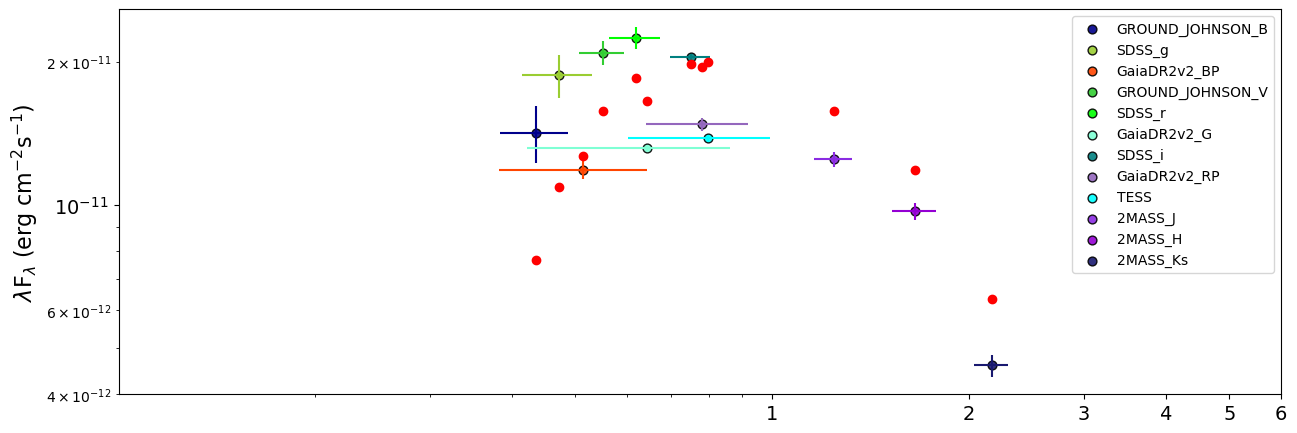

In [141]:
ymin = (flxs * wave).min()
ymax = (flxs * wave).max()

f, ax = plt.subplots(figsize=[15,5])

# Model plot
used_f = s.filter_names[s.filter_mask]

colors = np.array(['tomato', 'indianred', 'tab:red',
            'salmon', 'coral',
            'mediumorchid', 'mediumslateblue', 'tab:blue',
            'darkslateblue', 'darkblue',
            'olivedrab', 'yellowgreen', 'greenyellow', 'yellow',
            'orangered', 'chocolate', 'khaki',
            'limegreen', 'darkgreen', 'lime', 'seagreen', 'lawngreen', 'green',
            'aquamarine', 'turquoise', 'lightseagreen', 'teal', 'cadetblue',
            'tab:pink', 'tab:purple', 'tab:cyan', 'aqua', 'azure', 'dodgerblue',
            'firebrick', 'darkred',
            'blueviolet', 'darkviolet',
            'midnightblue', 'blue',
            'deeppink', 'fuchsia', 'mediumslateblue'])


for c, w, fl, fe, bp, fi in zip(
                colors[s.filter_mask],
                s.wave[s.filter_mask], s.flux[s.filter_mask], s.flux_er[s.filter_mask],
                s.bandpass[s.filter_mask], used_f):
    ax.errorbar(w, fl * w, xerr=bp, yerr=fe * w, fmt='', ecolor=c, marker=None)

    ax.scatter(w, fl * w, edgecolors='black', marker='o', c=c, s=40,
               alpha=.9, label=fi)
   

print(test*wave)
ax.plot(wave, test*wave*4.5e-8, 'or')

#ax.set_ylim([ymin * .8, ymax * 1.25])
ax.set_xscale('log', nonpositive='clip')
ax.set_yscale('log', nonpositive='clip')
ax.set_ylabel(r'$\lambda$F$_\lambda$ (erg cm$^{-2}$s$^{-1}$)', fontsize=16)
ax.legend(loc=0)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor')
ax.set_xticks(np.linspace(1, 10, 10))
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.1, 6])

#for tick in ax.get_yticklabels():
#    tick.set_fontname(self.fontname)